In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

# initializing lemmatizer
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wordnet_lemmatizer.lemmatize)
 
# ===========helper methods ========================================
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

def stop_words_list():
    """
        A stop list specific to the observed timelines composed of noisy words
        This list would change for different set of timelines
    """
    stop_words = ['bc', 'http', 'https', 'co', 'rt', 'one', 'us', 'new',
              'lol', 'may', 'get', 'want', 'like', 'love', 'no', 'thank', 'would', 'thanks',
              'via', 'today', 'gt', 'great', 'watch', 'watched', 'season',
              '00p']

    stoplist  = set( nltk.corpus.stopwords.words("english") + stop_words)
    return stoplist

def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

def tokenize(text):
    """
    helper function to readTweets() removes url and tokenizes text
    :param text
    """
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = re.sub(r"""[\'\"]""",'', text)
    regexps = (
        r"""(?:[\w_]+)""",                          # regular word
        r"""(?:[a-z][a-z'\-_]+[a-z])"""             # word with an apostrophe or a dash
    )
    tokens_regexp = re.compile(r"""(%s)""" % "|".join(regexps),
                               re.VERBOSE | re.I | re.UNICODE)
    return tokens_regexp.findall(text)

def replace_acronym(tokens, slang_dict):
    new_tokens = []
    for token in tokens:
        if token in slang_dict:
            new_tokens.extend(slang_dict[token].split())
        else:
            new_tokens.append(token)
    return new_tokens

def tokenize_and_lemmatize(text, slang_dict, stop_words):
    # get the tokens, lowercase - replace acronym
    lowered = [item.lower() for item in tokenize(text)]
    tokens = replace_acronym(lowered, slang_dict)

    
    tokens_pos = pos_tag(tokens)
    words = []
    for token in tokens_pos:
        pos = get_wordnet_pos(token[1])
        # if verb, noun, adj or adverb include them after lemmatization
        if pos is not None and token[0] not in stop_words:
            try:
                tok = lemmatize(token[0], pos)
                words.append(tok)
            except UnicodeDecodeError:
                pass
    # print words
    return words

def read_in_dict(filename):
    dict = {}
    with open(filename) as f:
        for line in f.readlines():
            parts = line.partition(":")
            dict[parts[0].strip()] = parts[2].strip()
    return dict

In [2]:
test_df = pd.read_csv("data/cluster_test1.csv",  low_memory=False)

Reading the data set

In [3]:
print(test_df[:5])

   Unnamed: 0      label                                              tweet  \
0           0  #politics  Not Just Trump: Jon Stewart Has Some Harsh Cri...   
1           1  #politics  Republicans are selling their souls to Donald ...   
2           2  #politics  RT @cyberguy: How the #Smartphone is Going to ...   
3           3  #politics  This Unusual Indicator Confirms That The Tech ...   
4           4  #politics  CBS News Caught Blatantly Distorting Cannabis ...   

                 user  
0  730453633838551041  
1  730453560660348929  
2  730453437654155264  
3  730453408444977152  
4  730453407316717568  


In [4]:
# convert the pandas series (tweet text) to numpy array
text = test_df.iloc[:, 2]
tweet_text = np.array(text)

Take the column of tweet text and convert to numpy array, for use in tfidf

In [5]:
def get_tfidf_model(texts, stop_words= None, slang_dict=None):
    stop_words = stop_words_list()
    vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 )

    #print ("vocabulary_: ", vectorizer.vocabulary_)
    
    tfidf_model = vectorizer.fit_transform(texts)
    return tfidf_model
    

slang_dict = read_in_dict("data/out_slang_map.csv")
tfidf_model = get_tfidf_model(tweet_text[:1000], stop_words_list(), slang_dict)

print(tfidf_model.shape)

(240, 174)


In [6]:
# gmm maximisation
clf = mixture.GMM(n_components=10, n_iter=500, n_init=10)
print (clf)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=10, n_iter=500, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


Aikaki Information Criteria(AIC) and the Bayesian Information Criterion(BIC)

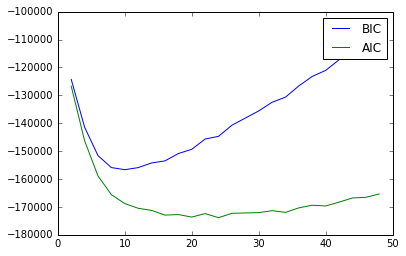

In [7]:
n_estimators = np.arange(2,50, step=2)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

n             bic              aic 
2             -126047              -128473
3             -137178              -140818
4             -142151              -147006
5             -149246              -155316
6             -153617              -160902
7             -154587              -163086
8             -156578              -166293
9             -156823              -167753
10             -155200              -167344
11             -154754              -168112


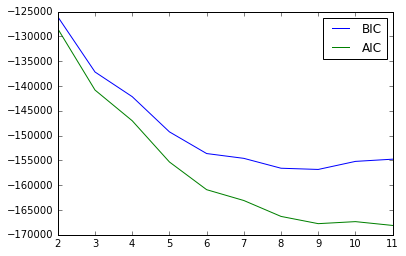

In [8]:
n_estimators = np.arange(2,12, step=1)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

i = 1
print("n             bic              aic ")
for x, y in zip(bics, aics):
    i += 1
    print("%d             %d              %d" % (i, x, y) )

In [9]:
# Log probabilities of each data point in tfarray
clf = mixture.GMM(n_components=9, n_iter=500).fit(tfarray)
print( clf.score(tfarray))


[ 367.88520146  354.3143163   365.20165015  372.99027474  366.0150812
  373.00768313  376.25600751  378.78181414  371.39462117  359.74845179
  376.26904227  371.43542344  382.43427524  372.59439301  383.68868927
  332.26035326  367.48371026  370.90904086  349.43163884  376.45787829
  373.34592986  359.31549534  372.95383578  367.88520146  383.68868927
  383.68868927  358.4863688   360.80923149  380.05648385  375.97182132
  338.32198242  357.9422028   371.56266231  384.11562446  384.12813494
  357.74997458  371.28160161  383.97039296  380.07924678  354.83943686
  375.13017774  379.02219781  366.07656644  384.11562446  384.80707782
  367.99403403  364.74323643  384.11562446  343.14079732  362.10516386
  384.80707782  357.62687069  352.49183855  367.01538359  373.47402313
  383.43694936  344.65794325  379.13538428  379.36676578  383.29326614
  376.40056728  333.98788113  319.4602114   358.28873101  375.07932653
  361.01194194  363.21094273  368.33356777  375.07932653  353.96271184
  369.2

<hr>
<b> GMM EM gives 9 clusters </b>


In [16]:
# true labels
t_labels = test_df.iloc[:, 1]

# run k means :
clusters = 9
km_model = KMeans(n_clusters=clusters)
cluster = km_model.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.113138
Adjusted Rand Score                : 0.812494
Adjusted Mutual Information Score  : 0.816198
Normalized Mutual Information Score: 0.842780
Normalized Mutual Information Score: 0.842780
Homogeniety Score                  : 0.858693
Completeness Score                 : 0.827162


In [17]:
# run Birch:
birch = Birch(n_clusters=clusters)
cluster = birch.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.071573
Adjusted Rand Score                : 0.421973
Adjusted Mutual Information Score  : 0.493505
Normalized Mutual Information Score: 0.528886
Normalized Mutual Information Score: 0.528886
Homogeniety Score                  : 0.533363
Completeness Score                 : 0.524446


In [18]:
# run SpectralClustering
spectral = SpectralClustering(n_clusters=clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
cluster = spectral.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.079834
Adjusted Rand Score                : 0.352484
Adjusted Mutual Information Score  : 0.573059
Normalized Mutual Information Score: 0.611856
Normalized Mutual Information Score: 0.611856
Homogeniety Score                  : 0.600182
Completeness Score                 : 0.623757


In [21]:
# db scan
dbscan = DBSCAN(eps=.2)
cluster = dbscan.fit_predict(tfidf_model)
print("clusters by DBSCAN: %d" % len(set(cluster)))
# result analysis :
if len(set(cluster)) > 1 :
    print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))


clusters by DBSCAN: 1
Adjusted Rand Score                : 0.000000
Adjusted Mutual Information Score  : 0.000000
Normalized Mutual Information Score: 0.000004
Normalized Mutual Information Score: 0.000004
Homogeniety Score                  : 0.000000
Completeness Score                 : 1.000000
